# Coresets with DPPs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline
%load_ext autoreload 
%autoreload 2

## Inspection

### Data generation

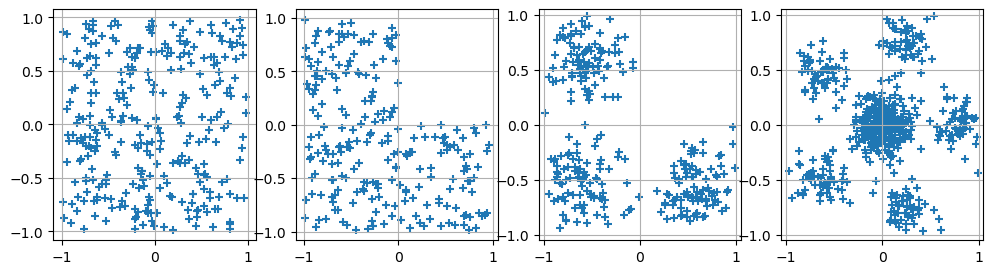

In [3]:
from utils import get_hypercube_data, get_cluster_data, get_circle_data
n, d, k = 300, 2, 3

plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
X = get_hypercube_data(n, d, border=.99)
plt.scatter(X[:,0], X[:,1], marker="+"), plt.grid()

plt.subplot(1,4,2)
X = get_hypercube_data(n, d, border=.99, remove_subcube=True)
plt.scatter(X[:,0], X[:,1], marker="+"), plt.grid()

plt.subplot(1,4,3)
X = get_cluster_data(n, d, k, border=.99)
plt.scatter(X[:,0], X[:,1], marker="+"), 
xylim = 1.05
plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim), plt.grid()

plt.subplot(1,4,4)
X1 = get_circle_data(n, d, 5, radius=.8, variance=1/50, border=.99)
X2 = get_circle_data(n, d, 1, radius=0, variance=1/50, border=.99)
X = np.concatenate((X1, X2))
plt.scatter(X[:,0], X[:,1], marker="+"), 
xylim = 1.05
plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim), plt.grid(), plt.show();

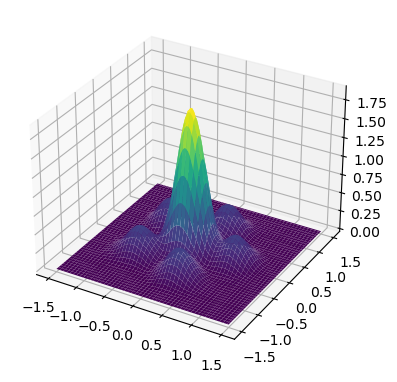

In [4]:
from sklearn.neighbors import KernelDensity
from utils import plot3d_func

kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(X)
gamma_tilde_pdf = lambda X: np.exp(kde.score_samples(X))

plt.figure(figsize=(10,5))
ax = plt.subplot(121, projection="3d")
plot3d_func(ax, gamma_tilde_pdf, 100)

### Sensitivity

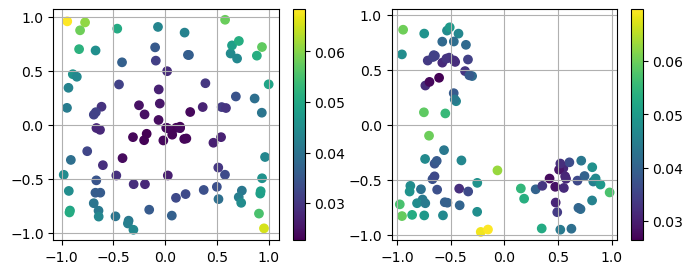

In [4]:
from utils import get_true_sensit

d, n, k = 2, 100, 3
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
X = get_hypercube_data(n, d)
sensit = get_true_sensit(X, 3)
plt.scatter(X[:,0], X[:,1], c=sensit)
plt.colorbar(), plt.grid()
plt.subplot(1,2,2)
X = get_cluster_data(n, d, k)
sensit = get_true_sensit(X, k)
plt.scatter(X[:,0], X[:,1], c=sensit)
xylim = 1.05
plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
plt.colorbar(), plt.grid(), plt.show();

### Gaussian k-DPP weights check

approximately m=5.000


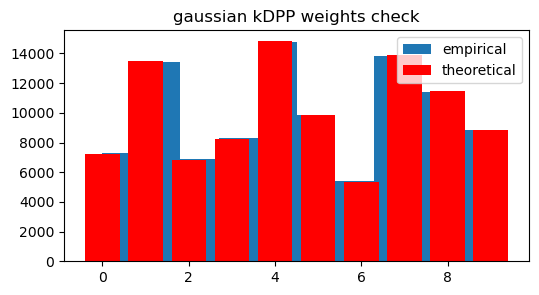

In [4]:
from samplers import gaussian_kernel, get_kDPP_weights, draw_gaussian_kDPP

d, n, m, k = 2, 10, 5, 3
nb_samples = 20000
X = get_hypercube_data(n, d, border=.99)
bandwidth = 1

likelihood = gaussian_kernel(X, bandwidth)
weights = get_kDPP_weights(likelihood, m)
samples, _ = draw_gaussian_kDPP(X, m, nb_samples, bandwidth)
samples = samples.flatten()
print(f"approximately m={(1/(n*weights)).sum():.3f}")
plt.figure(figsize=(6,3))
plt.hist(samples, density=False, label="empirical")
plt.bar(np.arange(len(X)), nb_samples/(n*weights), color='r', label="theoretical")
plt.title("gaussian kDPP weights check"), plt.legend();

### Sampling example

obtained n=279


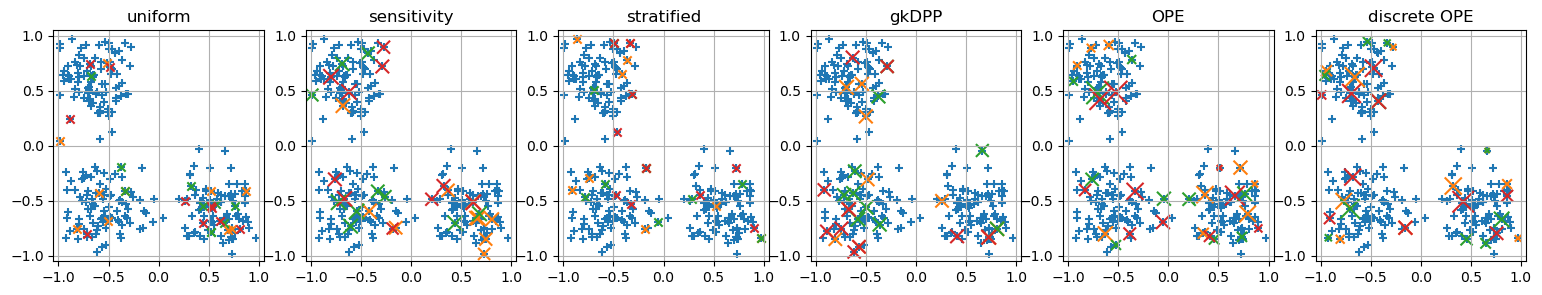

In [5]:
from samplers import draw_uniform, draw_sensitivity, draw_stratified, draw_gaussian_kDPP, draw_OPE, draw_discrete_OPE

d, desired_n, m, k = 2, 300, 10, 3
nb_samples = 3
# X = get_hypercube_data(desired_n, d, border=.99, remove_subcube=True)
X = get_cluster_data(desired_n, d, k, border=.99)
# X = get_cluster_data(desired_n, d, k, variance=1/10, border=.99)
# X1 = get_circle_data(desired_n/3, d, 3, radius=.8, variance=1/300, border=.99)
# X2 = get_circle_data(desired_n, d, 1, radius=0, variance=1/50, border=.99)
# X = np.concatenate((X1, X2))
n = len(X)
print(f"obtained n={n}")

uniform_samples = draw_uniform(len(X), m, nb_samples)
X_uniform = X[uniform_samples]
sensit_samples, sensit_weights = draw_sensitivity(X, m, nb_samples, k, .1)
X_sensit = X[sensit_samples]
stratified_samples = draw_stratified(X, m, nb_samples)
X_stratified = X[stratified_samples]
gkDPP_samples, gkDPP_weights = draw_gaussian_kDPP(X, m, nb_samples, bandwidth=.1)
X_gkDPP = X[gkDPP_samples]
OPE_samples, OPE_weights = draw_OPE(X, m, nb_samples, ab_coeff=0, prop_uniform=.1)
X_OPE = X[OPE_samples]
dOPE_samples, dOPE_weights = draw_discrete_OPE(X, m, nb_samples)
X_dOPE = X[dOPE_samples]

titles = ["uniform","sensitivity","stratified","gkDPP","OPE","discrete OPE"]
weights = [None, sensit_weights, None, gkDPP_weights, OPE_weights, dOPE_weights]
plt.figure(figsize=(19,3))
for k, X_samples in enumerate([X_uniform, X_sensit, X_stratified, X_gkDPP, X_OPE, X_dOPE]):
    plt.subplot(1,len(titles),k+1)
    plt.scatter(X[:,0], X[:,1], marker='+')
    for i_sample in range(nb_samples):
        weight = None
        if weights[k] is not None: weight= 100*m*weights[k][i_sample]
        plt.scatter(X_samples[i_sample,:,0], X_samples[i_sample,:,1], marker="x", s=weight)
    xylim = 1.05
    plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim), plt.title(titles[k]), plt.grid()
    # plt.gca().set_xticklabels([]), plt.gca().set_yticklabels([])

## Statistics

### Variance rate

In [17]:
from utils import loss, relative_error

# data parameters
d, desired_n, k = 2, 1024, 3    # 2, 1024, 3
X = get_cluster_data(desired_n, d, k, border=.99)

# X = get_hypercube_data(desired_n, d, border=.99, remove_subcube=False)
# X = get_cluster_data(desired_n, d, k, variance=1/4, border=.99)
# X1 = get_circle_data(desired_n/2, d, 5, radius=.8, variance=1/50, border=.99)
# X2 = get_circle_data(desired_n/2, d, 1, radius=0, variance=1/50, border=.99)
# X1 = get_circle_data(10, d, 1, radius=.8, variance=1/300, border=.99)
# X2 = get_circle_data(desired_n, d, 1, radius=0, variance=1/50, border=.99)
# X = np.concatenate((X1, X2))
n = len(X)
print(f"obtained n={n}")

# repetitions parameters
nb_rep = 1000
# queries = X[np.random.choice(n, (10,k), replace=False)]
queries = np.zeros((1,1,X.shape[-1]))
ms = np.arange(1,7, dtype=int)**2 # (1,14)
print(f"m list={ms}")

# init
kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(X)
kde_distr = np.exp(kde.score_samples(X))
SE_means, SE_stds, relerrs = [], [], []
loss_X = loss(X)
nb_ms, nb_queries = len(ms), len(queries)

for id_query, query in enumerate(queries):
    # draw queries
    print(f"draw query {id_query+1}/{nb_queries}")

    for m in ms:
        print(f"m={m}")
        # sample
        uniform_samples = draw_uniform(n, m, nb_rep)
        sensit_samples, sensit_weights = draw_sensitivity(X, m, nb_rep, k, delta=.1)
        # stratified_samples = draw_stratified(X, m, nb_rep)
        # gkDPP_samples, gkDPP_weights = draw_gaussian_kDPP(X, m, nb_rep, bandwidth=.1)
        OPE_samples, OPE_weights = draw_OPE(X, m, nb_rep, gamma_X=kde_distr, prop_uniform=0)
        dOPE_samples, dOPE_weights = draw_discrete_OPE(X, m, nb_rep)

        # compute loss
        loss_uniform = loss(X, query, uniform_samples)
        loss_sensit = loss(X, query, sensit_samples, sensit_weights)
        # loss_stratified = loss(X, query, stratified_samples)
        # loss_gkDPP = loss(X, query, gkDPP_samples, gkDPP_weights)
        loss_OPE = loss(X, query, OPE_samples, OPE_weights)
        loss_dOPE = loss(X, query, dOPE_samples, dOPE_weights)

        # compute metrics
        # loss_samples = np.array([loss_uniform, loss_sensit, loss_stratified, loss_gkDPP, loss_OPE, loss_dOPE])
        loss_samples = np.array([loss_uniform, loss_sensit, loss_OPE, loss_dOPE])
        SEs = (loss_samples - loss_X)**2
        SE_means.append(SEs.mean(-1))
        SE_stds.append(SEs.std(-1))
        relerrs.append(relative_error(loss_samples, loss_X))

# aggregate metrics
relerrs_sup = np.array(relerrs).reshape(nb_queries, nb_ms, -1, nb_rep).max(0)
SE_means, SE_stds = np.array(SE_means).reshape(nb_queries, nb_ms, -1), np.array(SE_stds).reshape(nb_queries, nb_ms, -1)
SE_means_argmax = SE_means.argmax(0)
arr1, arr2 = np.ogrid[:nb_ms,:SE_means.shape[-1]]
SE_means_sup = SE_means[SE_means_argmax, arr1, arr2]
SE_stds_sup = SE_stds[SE_means_argmax, arr1, arr2]

obtained n=943
m list=[ 1  4  9 16 25 36]
draw query 1/1
m=1
m=4
m=9
m=16
m=25
m=36


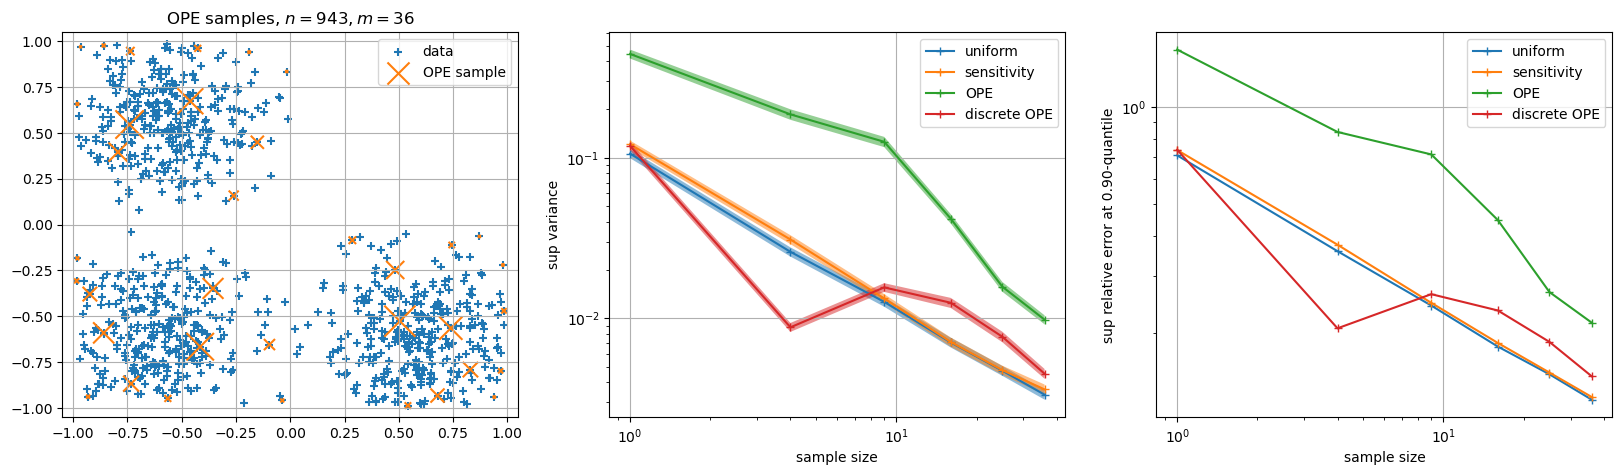

In [18]:
nb_stds = 1.5*nb_rep**(-.5)
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.scatter(X[:,0], X[:,1], marker="+", label="data")
X_samples, X_weights = X[OPE_samples[0]], 100*m*OPE_weights[0]
plt.scatter(X_samples[:,0],X_samples[:,1], marker="x", label="OPE sample", s=X_weights)
xylim = 1.05
plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
plt.title(f"OPE samples, $n={n}, m={m}$"), plt.legend(), plt.grid()

plt.subplot(132)
legends = ["uniform","sensitivity","stratified","gaussian kDPP","OPE", "discrete OPE"]
legends = ["uniform","sensitivity","OPE", "discrete OPE"]
plt.plot(ms, SE_means_sup, label=legends, marker="+")
for k, legend in enumerate(legends):
    plt.fill_between(ms, SE_means_sup[:,k]+nb_stds*SE_stds_sup[:,k], SE_means_sup[:,k]-nb_stds*SE_stds_sup[:,k], alpha=.5)
plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel("sup variance")
plt.legend(), plt.grid()

plt.subplot(133)
delta1, delta2 = .1, .01
relerr_quant1, relerr_quant2 = np.quantile(relerrs_sup, 1-delta1, axis=-1), np.quantile(relerrs_sup, 1-delta2, axis=-1)
plt.plot(ms, relerr_quant1, label=legends, marker="+")
# for k, legend in enumerate(legends):
#     plt.fill_between(ms, relerr_quant1[:,k], relerr_quant2[:,k], alpha=.5)
plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel(f"sup relative error at {1-delta1:.2f}-quantile")
plt.legend(), plt.grid(), plt.show();

In [37]:
d, n, k = 2, 700, 3    # 2, 1024, 3
X = get_hypercube_data(n, d, border=.99, remove_subcube=True)
# X = get_cluster_data(n, d, k, variance=1/4, border=.99)
# X1 = get_circle_data(n/3, d, 3, radius=.8, variance=1/300, border=.99)
# X2 = get_circle_data(n, d, 1, radius=0, variance=1/50, border=.99)
# X = np.concatenate((X1, X2))

kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(X)
oracle_distr = np.exp(kde.score_samples(X)) # .25 in uniform case
nb_rep, nb_query = 500, None

# ms = np.round(np.logspace(1, 6, num=10, base=2)).astype(int)
ms = np.arange(1, 8)**2 # (1,14)
bandwiths = [.001, .01, .05, .1, .7]
print(ms)
SE_means, SE_stds, relerrs = [], [], []
loss_X = loss(X)

for m in ms:
    print(f"m={m}")
    # sample
    uniform_samples = draw_uniform(len(X), m, nb_rep)
    gkDPP_samples1, gkDPP_weights1 = draw_gaussian_kDPP(X, m, nb_rep, bandwidth=bandwiths[0])
    gkDPP_samples2, gkDPP_weights2 = draw_gaussian_kDPP(X, m, nb_rep, bandwidth=bandwiths[1])
    gkDPP_samples3, gkDPP_weights3 = draw_gaussian_kDPP(X, m, nb_rep, bandwidth=bandwiths[2])
    gkDPP_samples4, gkDPP_weights4 = draw_gaussian_kDPP(X, m, nb_rep, bandwidth=bandwiths[3])
    gkDPP_samples5, gkDPP_weights5 = draw_gaussian_kDPP(X, m, nb_rep, bandwidth=bandwiths[4])
    # compute loss
    loss_uniform = loss(X, samples=uniform_samples)
    loss_gkDPP1 = loss(X, samples=gkDPP_samples1, weights=gkDPP_weights1[gkDPP_samples1])
    loss_gkDPP2 = loss(X, samples=gkDPP_samples2, weights=gkDPP_weights2[gkDPP_samples2])
    loss_gkDPP3 = loss(X, samples=gkDPP_samples3, weights=gkDPP_weights3[gkDPP_samples3])
    loss_gkDPP4 = loss(X, samples=gkDPP_samples4, weights=gkDPP_weights4[gkDPP_samples4])
    loss_gkDPP5 = loss(X, samples=gkDPP_samples5, weights=gkDPP_weights5[gkDPP_samples5])
    loss_samples = np.array([loss_uniform, loss_gkDPP1, loss_gkDPP2, loss_gkDPP3, loss_gkDPP4, loss_gkDPP5])
    # compute metrics
    SEs = (loss_samples - loss_X)**2
    SE_means.append(SEs.mean(-1))
    SE_stds.append(SEs.std(-1))
    relerrs.append(relative_error(loss_samples, loss_X))
relerrs = np.array(relerrs)
SE_means, SE_stds = np.array(SE_means), np.array(SE_stds)

[ 1  4  9 16 25 36 49]
m=1
m=4
m=9
m=16
m=25
m=36
m=49


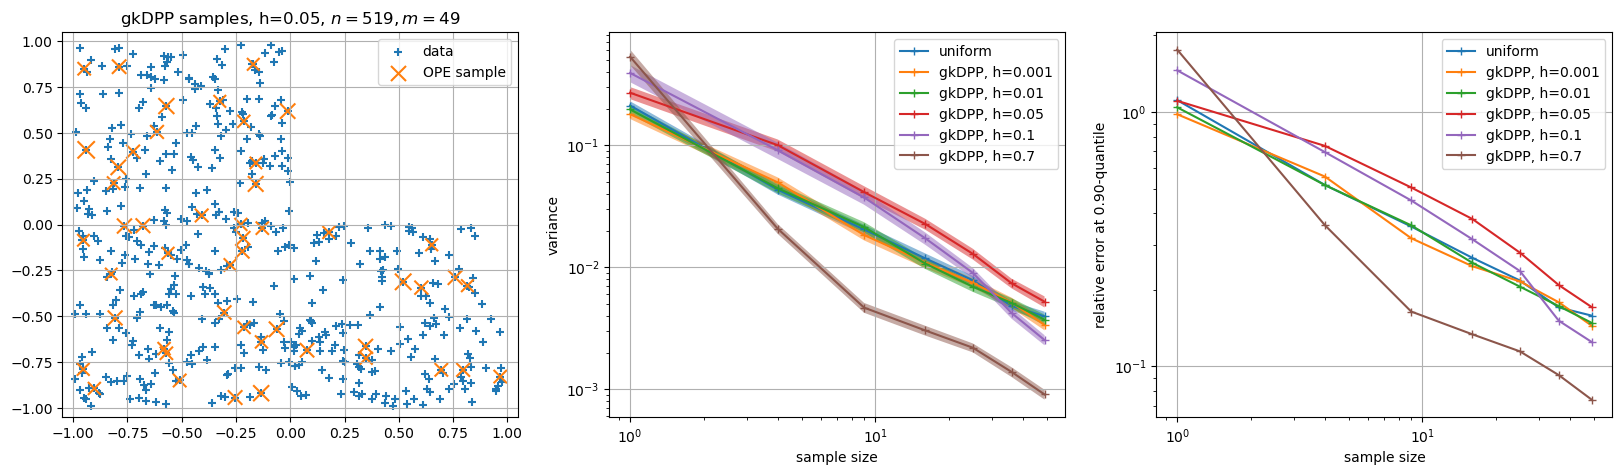

In [38]:
nb_stds = 1.5*nb_rep**(-.5)
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.scatter(X[:,0], X[:,1], marker="+", label="data")
DPP_sample = gkDPP_samples3[0]
plt.scatter(X[DPP_sample,0],X[DPP_sample,1], marker="x", label="OPE sample", s=100*m*gkDPP_weights3[DPP_sample])
xylim = 1.05
plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
plt.title(f"gkDPP samples, h={bandwiths[2]}, $n={len(X)}, m={m}$"), plt.legend(), plt.grid()

plt.subplot(132)
legends = ["uniform"]+["gkDPP, h="+str(bandwith) for bandwith in bandwiths]
plt.plot(ms, SE_means, label=legends, marker="+")
for k, legend in enumerate(legends):
    plt.fill_between(ms, SE_means[:,k]+nb_stds*SE_stds[:,k], SE_means[:,k]-nb_stds*SE_stds[:,k], alpha=.5)
plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel("variance")
plt.legend(), plt.grid()

plt.subplot(133)
delta1, delta2 = .1, .01
relerr_quant1, relerr_quant2 = np.quantile(relerrs, 1-delta1, axis=-1), np.quantile(relerrs, 1-delta2, axis=-1)
plt.plot(ms, relerr_quant1, label=legends, marker="+")
plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel(f"relative error at {1-delta1:.2f}-quantile")
plt.legend(), plt.grid(), plt.show();

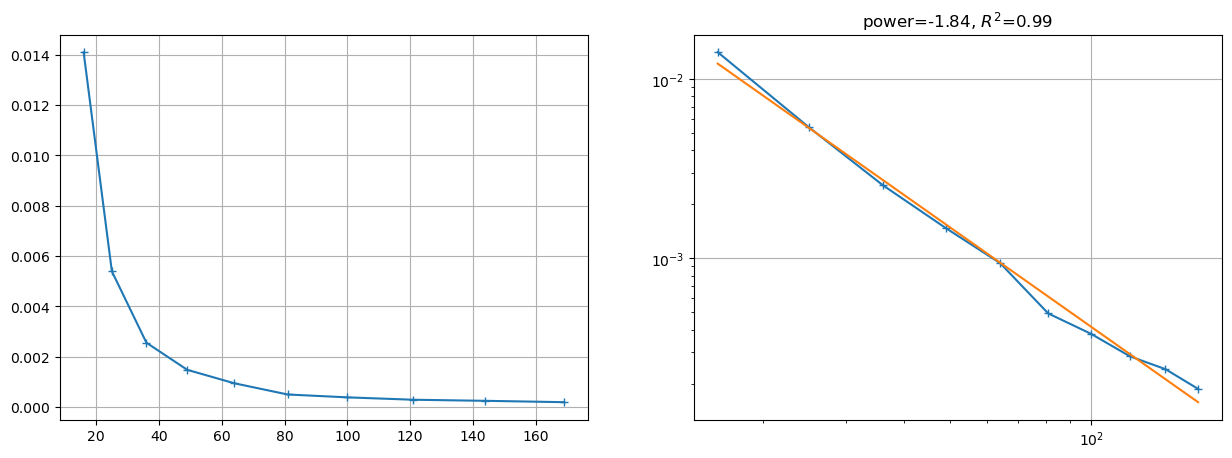

In [44]:
k_start, k_end = 3, None
plt.figure(figsize=(15,5))
fitted_reg = power_regression(ms[k_start:k_end], SE_means[:,2][k_start:k_end])

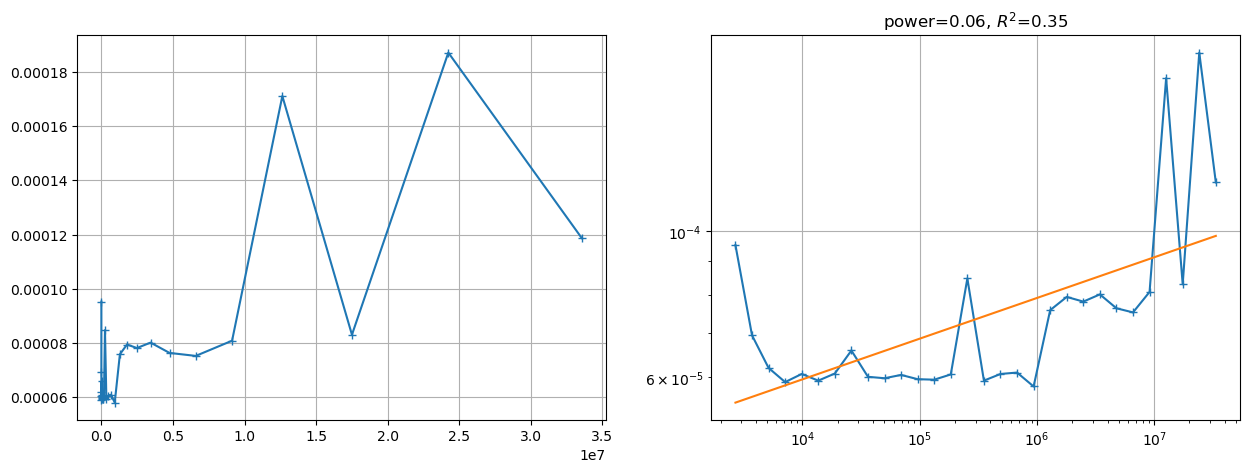

In [27]:
from sklearn.linear_model import LinearRegression

def power_regression(x, y):
    plt.subplot(121)
    plt.plot(x, y, marker="+"), plt.grid()
    logx, logy = np.log(x)[:,None], np.log(y)
    reg = LinearRegression().fit(logx, logy)
    power, factor = reg.coef_, np.exp(reg.intercept_)
    R_squared = reg.score(logx, logy)
    
    plt.subplot(122)
    plt.plot(x, y, marker="+")
    plt.plot(x, np.exp(reg.predict(logx)))
    plt.xscale('log'), plt.yscale('log')
    plt.title(f"power={power[0]:.2f}, $R^2$={R_squared:.2f}"), plt.grid();
    return reg

k_start = 20
plt.figure(figsize=(15,5))
fitted_reg = power_regression(n_list[k_start:], elapsed_times[k_start:])

### Benchmark DPPy sample_exact

In [26]:
from timeit import default_timer as timer
elapsed_times = []
n_list = []
d, n, nb_rep = 2, 2000, 10
ns = np.round(np.logspace(2, 25, num=50, base=2)).astype(int) # 20
# ns = np.arange(1, 30)**4
print(ns)
ab_coeff = 0
ab_coeff_array = np.zeros((d,2)) + ab_coeff
for n in ns:
    print(f"n={n}")
    start_time = timer()
    for rep in range(nb_rep):
        # X = get_hypercube_data(n, d)
        # obtain P which decompose continuous DPP K = PP^T
        # dpp = MultivariateJacobiOPE(m, ab_coeff_array)
        # polynom_X = dpp.eval_multiD_polynomials(X)
        # eig_vals, eig_vecs, weights = draw_OPE(X, int(m), gamma_X=.25)
        # OPE_samples = get_DPP_samples(eig_vals[:m], eig_vecs[:,:m], nb_samples=2)
        # gamma_tilde = stats.gaussian_kde(X.T)
        # gamma_X = gamma_tilde.pdf(X.T)
        truc= np.round(n*np.random.rand(nb_rep))
    n_list.append(n)
    elapsed_times.append(timer() - start_time)

[       4        6        8       11       15       20       28       39
       54       75      104      143      198      275      380      527
      729     1010     1398     1935     2680     3710     5136     7111
     9846    13632    18874    26131    36179    50090    69351    96018
   132939   184057   254831   352820   488487   676320   936380  1296439
  1794947  2485144  3440736  4763774  6595549  9131681 12643011 17504524
 24235395 33554432]
n=4
n=6
n=8
n=11
n=15
n=20
n=28
n=39
n=54
n=75
n=104
n=143
n=198
n=275
n=380
n=527
n=729
n=1010
n=1398
n=1935
n=2680
n=3710
n=5136
n=7111
n=9846
n=13632
n=18874
n=26131
n=36179
n=50090
n=69351
n=96018
n=132939
n=184057
n=254831
n=352820
n=488487
n=676320
n=936380
n=1296439
n=1794947
n=2485144
n=3440736
n=4763774
n=6595549
n=9131681
n=12643011
n=17504524
n=24235395
n=33554432


In [25]:
np.random.choice(n, nb_rep), np.random.rand(n, nb_rep).shape

(array([20451574,  6466630, 30246717, 25200919,  1867114, 11104117,
         2257348, 16958323,  4892921, 30294148]),
 (33554432, 10))